## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\benja\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[128, 64, 128], ratio=[], regulizer=None):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        ratio_in = []
        if regulizer.__name__ == 'l1':
            ratio_in.append(ratio['l1'])
        elif regulizer.__name__ == 'l2':
            ratio_in.append(ratio['l2'])
        else:
            ratio_in.append(ratio['l1'])
            ratio_in.append(ratio['l2'])
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regulizer(*ratio_in))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regulizer(*ratio_in))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
l1_ratio = [1e-2, 1e-4]
l2_ratio = [1e-2, 1e-4]
MOMENTUM = 0.95
ratio_mix = []
LEARNING_RATE = 0.01
BATCH_SIZE = 256
EPOCHS = 30
opts = [l1, l2, l1_l2]
for opt in opts:
    print(opt.__name__)
for l1_r in l1_ratio:
    for l2_r in l2_ratio:
        temp = {}
        temp['l1'] = l1_r
        temp['l2'] = l2_r
        ratio_mix.append(temp)
print(ratio_mix)

l1
l2
l1_l2
[{'l1': 0.01, 'l2': 0.01}, {'l1': 0.01, 'l2': 0.0001}, {'l1': 0.0001, 'l2': 0.01}, {'l1': 0.0001, 'l2': 0.0001}]


In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer in opts:
    for ratio in ratio_mix:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %s" % (regulizer.__name__))
        model = build_mlp(input_shape=x_train.shape[1:], ratio=ratio, regulizer=regulizer)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "regu-{} l1 {} l2 {}".format(regulizer, ratio['l1'], ratio['l2'])
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer = l1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               8320      
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 411,210
Trainable params: 411,210
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================]

50000/50000 [==============================] - 8s 167us/step - loss: 2.6805 - acc: 0.0988 - val_loss: 2.6807 - val_acc: 0.1000
Epoch 15/30
50000/50000 [==============================] - 9s 170us/step - loss: 2.6806 - acc: 0.0990 - val_loss: 2.6807 - val_acc: 0.1000
Epoch 16/30
50000/50000 [==============================] - 8s 168us/step - loss: 2.6805 - acc: 0.0980 - val_loss: 2.6802 - val_acc: 0.1000
Epoch 17/30
50000/50000 [==============================] - 9s 171us/step - loss: 2.6805 - acc: 0.0975 - val_loss: 2.6807 - val_acc: 0.1000
Epoch 18/30
50000/50000 [==============================] - 8s 165us/step - loss: 2.6805 - acc: 0.0988 - val_loss: 2.6806 - val_acc: 0.1000
Epoch 19/30
50000/50000 [==============================] - 8s 158us/step - loss: 2.6805 - acc: 0.1006 - val_loss: 2.6809 - val_acc: 0.1000
Epoch 20/30
50000/50000 [==============================] - 7s 147us/step - loss: 2.6805 - acc: 0.0991 - val_loss: 2.6810 - val_acc: 0.1000
Epoch 21/30
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 157us/step - loss: 2.8277 - acc: 0.3164 - val_loss: 2.6283 - val_acc: 0.3704
Epoch 2/30
50000/50000 [==============================] - 8s 151us/step - loss: 2.4657 - acc: 0.4071 - val_loss: 2.3367 - val_acc: 0.4322
Epoch 3/30
50000/50000 [==============================] - 8s 151us/step - loss: 2.2653 - acc: 0.4377 - val_loss: 2.2340 - val_acc: 0.4337
Epoch 4/30
50000/50000 [==============================] - 8s 151us/step - loss: 2.1173 - acc: 0.4585 - val_loss: 2.0659 - val_acc: 0.4515
Epoch 5/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.9954 - acc: 0.4707 - val_loss: 1.9606 - val_acc: 0.4733
Epoch 6/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.9059 - acc: 0.4790 - val_loss: 2.0166 - val_acc: 0.4314
Epoch 7/30
50000/50000 [==============================] - 8s 164us/step - loss: 1.8315 - acc: 0.4845 - val_loss: 1.9698 - 

Epoch 22/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7715 - acc: 0.4319 - val_loss: 1.8608 - val_acc: 0.3841
Epoch 23/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7652 - acc: 0.4300 - val_loss: 1.8113 - val_acc: 0.4126
Epoch 24/30
50000/50000 [==============================] - 8s 158us/step - loss: 1.7731 - acc: 0.4316 - val_loss: 1.7801 - val_acc: 0.4267
Epoch 25/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7673 - acc: 0.4332 - val_loss: 1.7176 - val_acc: 0.4511
Epoch 26/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.7617 - acc: 0.4323 - val_loss: 1.7545 - val_acc: 0.4355
Epoch 27/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.7999 - acc: 0.4216 - val_loss: 1.9961 - val_acc: 0.3532
Epoch 28/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.7880 - acc: 0.4222 - val_loss: 1.7588 - val_acc: 0.4264
Epoch 29/30
50000/50000 [==

50000/50000 [==============================] - 8s 152us/step - loss: 1.8231 - acc: 0.4101 - val_loss: 1.8524 - val_acc: 0.3989
Epoch 6/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.8027 - acc: 0.4187 - val_loss: 1.8349 - val_acc: 0.3999
Epoch 7/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.7944 - acc: 0.4239 - val_loss: 1.8431 - val_acc: 0.3983
Epoch 8/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.7872 - acc: 0.4258 - val_loss: 1.8193 - val_acc: 0.4126
Epoch 9/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7811 - acc: 0.4308 - val_loss: 1.7974 - val_acc: 0.4231
Epoch 10/30
50000/50000 [==============================] - 8s 153us/step - loss: 1.7725 - acc: 0.4309 - val_loss: 1.7561 - val_acc: 0.4369
Epoch 11/30
50000/50000 [==============================] - 8s 161us/step - loss: 1.7967 - acc: 0.4241 - val_loss: 1.8683 - val_acc: 0.3931
Epoch 12/30
50000/50000 [==================

50000/50000 [==============================] - 12s 236us/step - loss: 1.1264 - acc: 0.6218 - val_loss: 1.4692 - val_acc: 0.5145
Epoch 27/30
50000/50000 [==============================] - 12s 240us/step - loss: 1.1203 - acc: 0.6244 - val_loss: 1.4340 - val_acc: 0.5263
Epoch 28/30
50000/50000 [==============================] - 11s 215us/step - loss: 1.1041 - acc: 0.6283 - val_loss: 1.4660 - val_acc: 0.5220
Epoch 29/30
50000/50000 [==============================] - 9s 171us/step - loss: 1.0986 - acc: 0.6299 - val_loss: 1.5094 - val_acc: 0.5048
Epoch 30/30
50000/50000 [==============================] - 8s 164us/step - loss: 1.0889 - acc: 0.6366 - val_loss: 1.4798 - val_acc: 0.5240
Experiment with Regulizer = l1_l2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (D

50000/50000 [==============================] - 8s 169us/step - loss: 2.6805 - acc: 0.0991 - val_loss: 2.6806 - val_acc: 0.1000
Epoch 10/30
50000/50000 [==============================] - 9s 171us/step - loss: 2.6805 - acc: 0.0972 - val_loss: 2.6806 - val_acc: 0.1000
Epoch 11/30
50000/50000 [==============================] - 8s 168us/step - loss: 2.6804 - acc: 0.0982 - val_loss: 2.6810 - val_acc: 0.1000
Epoch 12/30
50000/50000 [==============================] - 8s 168us/step - loss: 2.6805 - acc: 0.0984 - val_loss: 2.6805 - val_acc: 0.1000
Epoch 13/30
50000/50000 [==============================] - 8s 168us/step - loss: 2.6804 - acc: 0.0994 - val_loss: 2.6806 - val_acc: 0.1000
Epoch 14/30
50000/50000 [==============================] - 8s 169us/step - loss: 2.6806 - acc: 0.0976 - val_loss: 2.6806 - val_acc: 0.1000
Epoch 15/30
50000/50000 [==============================] - 8s 170us/step - loss: 2.6805 - acc: 0.0983 - val_loss: 2.6806 - val_acc: 0.1000
Epoch 16/30
50000/50000 [==============

50000/50000 [==============================] - 9s 171us/step - loss: 1.8270 - acc: 0.4016 - val_loss: 1.9171 - val_acc: 0.3664
Experiment with Regulizer = l1_l2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               8320      
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 411,210
Trainable params: 411,210
Non-trainable params: 0
_________________________________________

12
regu-l1 l1 0.01 l2 0.01
regu-l1 l1 0.01 l2 0.0001
regu-l1 l1 0.0001 l2 0.01
regu-l1 l1 0.0001 l2 0.0001
regu-l2 l1 0.01 l2 0.01
regu-l2 l1 0.01 l2 0.0001
regu-l2 l1 0.0001 l2 0.01
regu-l2 l1 0.0001 l2 0.0001
regu-l1_l2 l1 0.01 l2 0.01
regu-l1_l2 l1 0.01 l2 0.0001
regu-l1_l2 l1 0.0001 l2 0.01
regu-l1_l2 l1 0.0001 l2 0.0001


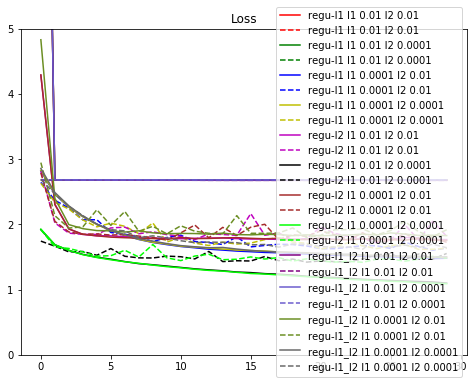

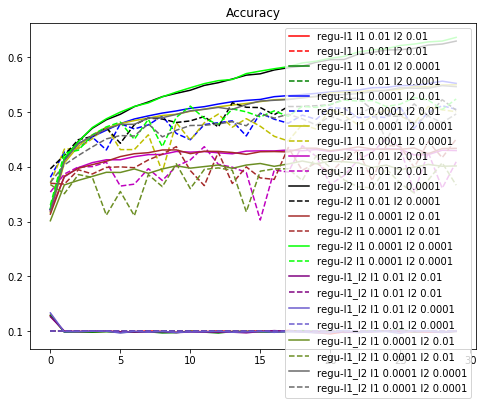

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
for regulizer in opts:
    for ratio in ratio_mix:
        exp_name_tag = "regu-{} l1 {} l2 {}".format(regulizer, ratio['l1'], ratio['l2'])
        results[exp_name_tag]['name'] = 'regu-{} l1 {:3} l2 {}'.format(regulizer.__name__, ratio['l1'], ratio['l2'])
print(len(results))
color_bar = ["r", "g", "b", "y", "m", "k", 'brown', 'lime', 'purple', 'slateblue', 'olivedrab' ,'dimgray']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(results[cond]['name'])
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=results[cond]['name'], color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=results[cond]['name'], color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='right')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=results[cond]['name'], color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=results[cond]['name'], color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()